## Fluid flow around a fault

Flow of fluids around a fault

From [Guy Simpson - Practical Finite Element Modeling in Earth Science using Matlab (2017)](https://www.wiley.com/en-au/Practical+Finite+Element+Modeling+in+Earth+Science+using+Matlab-p-9781119248620)

- Section 10.1 of the book

#### Transient evolution of excess pore pressure is:
$$ \phi \beta  \frac{\partial p_e}{\partial t} = \nabla \cdot \left( \frac{k(x,z)}{\mu}\nabla p_e \right)  $$

#### Fluid velocity corresponding to excess pore pressure field:
$$ u = - \frac{k}{\mu_c}\nabla p_e$$


##### Model physical parameters:

| parameter | symbol  | value  | units  |   |
|---|---|---|---|---|
| x |  | $$10$$  | $$m$$  |   |
| y  |  | $$10$$  | $$m$$  |   |
| permeability  | $$k$$ | $$10^{-13}$$  | $$m^2$$  |   |
| porosity  | $$\varphi$$ | $$0.1$$ |   |   |
| diffusivity  | $$\kappa$$  | $$10^{-9}$$  | $$m^2 s^{-1}$$  |   |
| viscosity (solvant)  | $$\eta{_s}$$ | $$1.33{\cdot}10^{-4}$$  | $$Pa s$$  |   |
| viscosity (oil)  | $$\eta{_o}$$ | $$20\eta_s$$  | $$Pa s$$  |   |
| pressure  | $$p$$  | $$10^{5}$$  | $$Pa$$  |   |

In [11]:
from petsc4py import PETSc
import underworld3 as uw
from underworld3.systems import Stokes
import numpy as np
import sympy
from mpi4py import MPI
import os
from copy import deepcopy 
options = PETSc.Options()

In [2]:
outputDir = './output/fluid_fault/'

if uw.mpi.rank==0:
    ### create folder if not run before
    if not os.path.exists(outputDir):
        os.makedirs(outputDir)

outfile = f"{outputDir}fault_"

In [3]:
# import unit registry to make it easy to convert between units
u = uw.scaling.units

### make scaling easier
ndim, nd = uw.scaling.non_dimensionalise, uw.scaling.non_dimensionalise
dim  = uw.scaling.dimensionalise 

res             = 96
boxLength       = 50e3              # length of domain      (m)
boxHeight       = 20e3              # height of domain      (m)
sim_years       = 11                # simulation time       (yrs)
sim_sec         = sim_years*31556926 # simulation time       (seconds)

fault_width     = 1.5e3               # width of the fault    (m) 
g               = 9.81              # gravity               (m/s^2)                
mu              = 1.33e-4           # fluid viscosity       (Pa.s)
perm_amb        = 1e-16             # ambient permeability  (m^2) # 1e-16
perm_fault      = 1e-16             # failt permeability    (m^2) # 1e-12
rho_amb         = 2700              # rock density (kg/m^3)
rho_fluid       = 1000              # fluid density (kg/m^3)
beta            = 1e-10             # bulk compressibility (1/Pa)
phi             = 0.1               # porosity
lamb            = 0.6               # pore pressure ratio
p_base          = lamb*rho_amb*g*boxHeight  # fixed fluid pressure at base (Pa)
p_base_h        = rho_fluid*g*boxHeight     # hydrostatic fluid pressure at base (Pa)
pe_base         = p_base - p_base_h         # excess overpressure at base (Pa)

do_plots = False


In [4]:
# set-up non-dimensionalization
seconds_per_yr = 60*60*24*365

refTime         = beta*mu # very small reference time ?
#refTime         = dt_fault
#refTime         = 0.1*seconds_per_yr

refViscosity   = mu * u.pascal * u.second

KL = np.sqrt(perm_amb/phi)   * u.meter
Kt = refTime                * u.second
KM = refViscosity           * KL * Kt

# KL = boxLength *u.meter
# Kt = 0.05*seconds_per_yr *u.second 
# KM = refViscosity*KL*Kt


### create unit registry
scaling_coefficients = uw.scaling.get_coefficients()
scaling_coefficients["[length]"] = KL
scaling_coefficients["[time]"] = Kt
scaling_coefficients["[mass]"]= KM

scaling_coefficients

[mass],5.593752953071847e-26 kilogram
[length],3.162277660168379e-08 meter
[temperature],1.0 kelvin
[time],1.33e-14 second
[substance],1.0 mole


In [5]:
minX, maxX = 0, nd(boxLength*u.meter)
minZ, maxZ = 0, nd(boxHeight*u.meter)

mesh = uw.meshing.UnstructuredSimplexBox(
    minCoords=(minX, minZ), maxCoords=(maxX, maxZ), cellSize=maxX/res, qdegree=3)

# mesh = uw.meshing.StructuredQuadBox(elementRes=(res,res),
#                                       minCoords=(minX,minZ),
#                                       maxCoords=(maxX,maxZ), qdegree=5 )


## define pressure, velocity and material on the mesh. 
p_soln      = uw.discretisation.MeshVariable("P", mesh, 1, degree=3         ) ## scalar
v_soln      = uw.discretisation.MeshVariable("U", mesh, mesh.dim, degree=2  ) ## vector (2d) 
diff_field  = uw.discretisation.MeshVariable("perm", mesh, 1, degree = 3    ) ## equivalent diffusivity field 

v_dummy = uw.discretisation.MeshVariable("Vd", mesh, mesh.dim, degree=2     ) ## vector (2d) 

# vector projection
v_calc = uw.systems.Vector_Projection(mesh, v_soln)
v_calc.uw_function = -diff_field.sym[0]*phi*nd(beta*1/u.pascal)*mesh.vector.gradient(p_soln.sym)
v_calc.smoothing = 1.0e-6
v_calc.petsc_options.delValue("ksp_monitor")

# x and y coordinates
x = mesh.N.x
z = mesh.N.y

In [8]:
## print out what the mesh looks like

if uw.mpi.size == 1:

    # plot the mesh
    import numpy as np
    import pyvista as pv
    import vtk

    pv.global_theme.background = "white"
    pv.global_theme.window_size = [750, 750]
    pv.global_theme.antialiasing = True
    pv.global_theme.jupyter_backend = "trame"
    pv.global_theme.smooth_shading = True

    mesh.vtk("tmp_mesh.vtk")
    pvmesh = pv.read("tmp_mesh.vtk")

    pl = pv.Plotter()

    pl.add_mesh(
        pvmesh,
        cmap="coolwarm",
        edge_color="Black",
        show_edges=True,
        use_transparency=False,
    )

    pl.show(cpos="xy")

Widget(value="<iframe src='http://localhost:51453/index.html?ui=P_0x283b4cd50_0&reconnect=auto' style='width: …

### Set advection-diffusion equation 
- There is no advection so set v_dummy to zero everywhere

In [9]:
adv_diff = uw.systems.AdvDiffusionSLCN(
                                        mesh,
                                        u_Field=p_soln,
                                        V_Field=v_dummy,
                                        solver_name="adv_diff",
                                    )

adv_diff.constitutive_model = uw.systems.constitutive_models.DiffusionModel(mesh.dim)

adv_diff.constitutive_model.Parameters.diffusivity = diff_field.sym[0]#perm_field.sym[0]/(phi*nd(beta/u.pascal)*nd(mu*u.pascal*u.second))
#perm_field.sym[0]/(phi*nd(beta/u.pascal)*nd(mu*u.pascal*u.second))

adv_diff.add_dirichlet_bc(nd(0*u.pascal), "Top")
adv_diff.add_dirichlet_bc(nd(pe_base*u.pascal), "Bottom")

In [10]:
#darcy.petsc_options["snes_atol"]    = 1.0e-6  # Needs to be smaller than the contrast in properties
adv_diff.petsc_options["snes_atol"] = 1.0e-6

#darcy.petsc_options["snes_rtol"]    = 1.0e-12  # Needs to be smaller than the contrast in properties
adv_diff.petsc_options["snes_rtol"] = 1.0e-12

adv_diff.petsc_options["snes_max_it"] = 500

In [11]:
adv_diff.constitutive_model.Parameters.diffusivity

perm(N.x, N.y)

# Set-up darcy flow equation forward model

### Initialize the fields 

In [12]:
# set the dummy velocity field
# with mesh.access(v_dummy):
#     for i, coords in enumerate(v_dummy.coords):
#         v_dummy.data[i, 0] = 0.
#         v_dummy.data[i, 1] = 0.

# permeability field encodes the effect of the presence of the fault
with mesh.access(diff_field):
    for i, coords in enumerate(diff_field.coords):
        
        cond2 = coords[1] >= (0.5*coords[0] - nd(2.5e3*u.meter)) and \
                    coords[1] <= (0.5*coords[0] + nd((fault_width*np.sqrt(1.25) - 2.5e3)*u.meter))
        cond1 = coords[1] >= (-2*coords[0] + nd(35e3*u.meter)) and \
                    coords[1] <= (-2*coords[0] + nd(85e3*u.meter))
        if cond1 and cond2:
           diff_field.data[i] = nd(perm_fault*u.meter*u.meter)/(phi*nd(beta/u.pascal)*nd(mu*u.pascal*u.second))
        else:
            diff_field.data[i] = nd(perm_amb*u.meter*u.meter)/(phi*nd(beta/u.pascal)*nd(mu*u.pascal*u.second))

# initial value of permeability
with mesh.access(p_soln):
    for i, coords in enumerate(p_soln.coords):
        p_soln.data[i] = (nd(boxHeight*u.meter) - coords[1])*nd(pe_base*u.pascal)/nd(boxHeight*u.meter)

In [13]:
print(nd(perm_fault*u.meter*u.meter)/(phi*nd(beta/u.pascal)*nd(mu*u.pascal*u.second)))
print(nd(perm_amb*u.meter*u.meter)/(phi*nd(beta/u.pascal)*nd(mu*u.pascal*u.second)))

0.9999999999999999
0.9999999999999999


In [22]:

def plotFig(meshbox, s_field, v_field, s_field_name, save_fname = None, with_arrows = False, cmap = "coolwarm"): 
    """
    s_field - scalar field - corresponds to colors
    v_field - vector field - usually the velocity - 2 components
    """
    if uw.mpi.size == 1:

        import numpy as np
        import pyvista as pv
        import vtk

        pv.global_theme.background = "white"
        pv.global_theme.window_size = [750, 750]
        pv.global_theme.antialiasing = True
        pv.global_theme.jupyter_backend = "trame"
        pv.global_theme.smooth_shading = True

        meshbox.vtk("tmp_box_mesh.vtk")
        pvmesh = pv.read("tmp_box_mesh.vtk")

        velocity = np.zeros((meshbox.data.shape[0], 3))
        velocity[:, 0] = uw.function.evaluate(v_field.sym[0], meshbox.data)
        velocity[:, 1] = uw.function.evaluate(v_field.sym[1], meshbox.data)

        #pvmesh.point_data["V"] = velocity / 10

        points = np.zeros((s_field.coords.shape[0], 3))
        points[:, 0] = s_field.coords[:, 0]
        points[:, 1] = s_field.coords[:, 1]

        point_cloud = pv.PolyData(points)

        with meshbox.access():
            point_cloud.point_data[s_field_name] = uw.function.evaluate(s_field.fn, points[:, 0:2])

        skip = 2
        num_row = len(meshbox._centroids[::skip, 0])

        cpoints = np.zeros((num_row, 3))
        cpoints[:, 0] = meshbox._centroids[::skip, 0]
        cpoints[:, 1] = meshbox._centroids[::skip, 1]

        cpoint_cloud = pv.PolyData(cpoints)

        # pvstream = pvmesh.streamlines_from_source(
        #     cpoint_cloud,
        #     vectors="V",
        #     integrator_type=2,
        #     integration_direction="forward",
        #     compute_vorticity=False,
        #     max_steps=1000,
        #     surface_streamlines=True,
        # )
 
        pl = pv.Plotter()

        with meshbox.access():
            skip = 2
        
            num_row = len(v_field.coords[::skip, 0:2])

            arrow_loc = np.zeros((num_row, 3))
            arrow_loc[:, 0:2] = v_field.coords[::skip, 0:2]

            arrow_length = np.zeros((num_row, 3))
            arrow_length[:, 0] = v_field.data[::skip, 0]
            arrow_length[:, 1] = v_field.data[::skip, 1]

        pl = pv.Plotter()

        #pl.add_mesh(pvmesh,'Gray', 'wireframe')

        pl.add_mesh(
            pvmesh, cmap=cmap, edge_color="Black",
            show_edges=True, use_transparency=False, opacity=0.1,
        )

      
        if with_arrows:
            pl.add_arrows(arrow_loc, arrow_length, mag=1e16, opacity=1)
        else:
            pl.add_points(point_cloud, cmap=cmap, point_size=18, opacity=0.8)


        # pl.add_mesh(pvstream, opacity=0.5)
        # pl.add_arrows(arrow_loc2, arrow_length2, mag=1.0e-1)

        # pl.add_points(pdata)

        pl.show(cpos="xy", jupyter_backend = "panel")

        if save_fname is not None:
            #pl.save_graphic(save_fname, dpi = 300)
            pl.image_scale = 3
            pl.screenshot(save_fname) 

        pvmesh.clear_data()
        pvmesh.clear_point_data()
        

In [ ]:
plotFig(mesh, diff_field, v_soln, "Perm", save_fname = None, with_arrows = False, cmap = "coolwarm")

In [23]:
plotFig(mesh, p_soln, v_soln, "Perm", save_fname = None, with_arrows = False, cmap = "coolwarm")

BokehModel(combine_events=True, render_bundle={'docs_json': {'d0630e53-3adb-48e1-a4ec-2e0d9780929c': {'version…

In [16]:
plotFig(mesh, p_soln, v_soln, "Pe", save_fname = None, with_arrows = False, cmap = "coolwarm")

BokehModel(combine_events=True, render_bundle={'docs_json': {'dccb9b89-4255-4945-8cc2-db181a2e7598': {'version…

In [17]:
# prepare coordinates to measure the pressure in
dy = 0.1e3
y = np.arange(0, boxHeight + dy, dy)
x = np.ones_like(y)*15e3

xy = np.vstack([x, y]).T
xy_ndim = nd(xy*u.meter)

In [18]:
dt = adv_diff.estimate_dt()
print(dt)

8.699445067078409e+18


/Users/jgra0019/Documents/codes/uw3-dev/underworld3/underworld3/systems/solvers.py:1078: RuntimeWarning: divide by zero encountered in scalar divide
  dt_adv = min_dx / max_magvel_glob


8.699445067078409e+18
  0 SNES Function norm 4.66498 
  1 SNES Function norm 9.86413e-05 
  2 SNES Function norm 7.454e-10 
Nonlinear adv_diff_ solve converged due to CONVERGED_FNORM_ABS iterations 2


/Users/jgra0019/mambaforge/envs/uw3-dev/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1335: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.asarray(x, float)


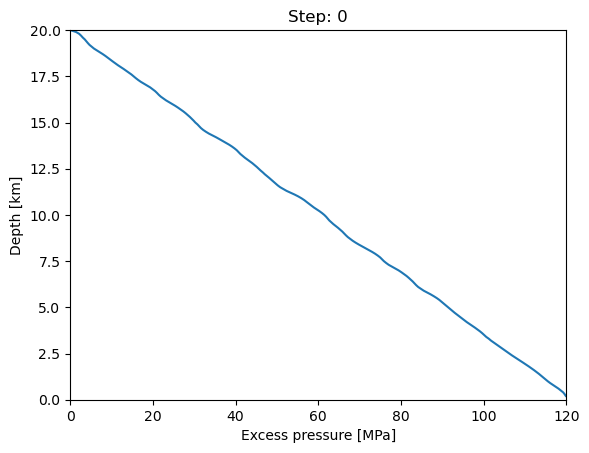

  0 SNES Function norm 1.72355e+07 
  1 SNES Function norm 56238.3 
  2 SNES Function norm 42.6492 
Nonlinear VProj1_ solve converged due to CONVERGED_FNORM_RELATIVE iterations 2
Saving mesh file
8.699445067078409e+18
  0 SNES Function norm 4.66309 
  1 SNES Function norm 9.86791e-05 
  2 SNES Function norm 7.438e-10 
Nonlinear adv_diff_ solve converged due to CONVERGED_FNORM_ABS iterations 2
8.699445067078409e+18
  0 SNES Function norm 4.66135 
  1 SNES Function norm 9.87296e-05 
  2 SNES Function norm 7.425e-10 
Nonlinear adv_diff_ solve converged due to CONVERGED_FNORM_ABS iterations 2
8.699445067078409e+18
  0 SNES Function norm 4.65972 
  1 SNES Function norm 9.87737e-05 
  2 SNES Function norm 7.414e-10 
Nonlinear adv_diff_ solve converged due to CONVERGED_FNORM_ABS iterations 2


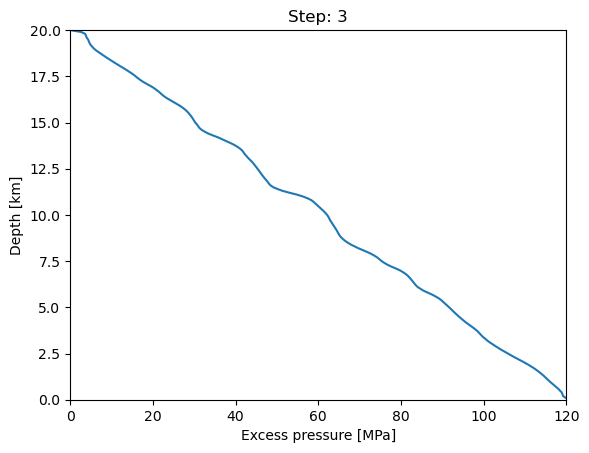

8.699445067078409e+18
  0 SNES Function norm 4.65818 
  1 SNES Function norm 9.88075e-05 
  2 SNES Function norm 7.405e-10 
Nonlinear adv_diff_ solve converged due to CONVERGED_FNORM_ABS iterations 2
8.699445067078409e+18
  0 SNES Function norm 4.65672 
  1 SNES Function norm 9.88313e-05 
  2 SNES Function norm 7.396e-10 
Nonlinear adv_diff_ solve converged due to CONVERGED_FNORM_ABS iterations 2


In [21]:
step = 0
nsteps = 6
save_every = 10


while step < nsteps:
    dt = adv_diff.estimate_dt()
    print(dt)
    adv_diff.solve(timestep = dt)
    #v_calc.solve()

    p_int = uw.function.evaluate(p_soln.sym[0], xy_ndim)

    if step%3 == 0 and uw.mpi.size == 1:
        import matplotlib.pyplot as plt
        """compare 1D and 2D models"""
        plt.figure()
        ### profile from UW
        plt.plot(dim(p_int, u.pascal)/1e6, y/1e3)
        ### numerical solution
        plt.xlabel("Excess pressure [MPa]")
        plt.ylabel("Depth [km]")
        plt.ylim([0, 20])
        plt.xlim([0, 120])
        plt.title(f"Step: {step}")
        plt.show()

    if step % save_every == 0:
        v_calc.solve()
        mesh.write_timestep_xdmf(filename = outfile, meshVars=[p_soln, v_soln], index = step)
        
        outfile

    step += 1

v_calc.solve()
mesh.write_timestep_xdmf(filename = outfile, meshVars=[p_soln, v_soln], index = step)
    

In [23]:
plotFig(mesh, p_soln, v_soln, "Pe", save_fname = None, with_arrows = False, cmap = "coolwarm")

BokehModel(combine_events=True, render_bundle={'docs_json': {'799d8e3f-c62e-46ef-b893-888cb1f6df77': {'version…

In [24]:
# v_calc.solve()

  0 SNES Function norm 1.8798e+07 
  1 SNES Function norm 28993.3 
  2 SNES Function norm 14.1947 
Nonlinear VProj1_ solve converged due to CONVERGED_FNORM_RELATIVE iterations 2


In [27]:
# with mesh.access(v_soln):
#     print(dim(v_soln.data[:, 0].min(), u.meter/u.second))
#     print(dim(v_soln.data[:, 1].min(),u.meter/u.second))
#     print(dim(v_soln.data[:, 0].max(), u.meter/u.second))
#     print(dim(v_soln.data[:, 1].max(),u.meter/u.second))

-7.430156937207076e-09 meter / second
2.56939122916318e-10 meter / second
7.192314516882817e-09 meter / second
3.9745170468361744e-08 meter / second


/Users/jgra0019/mambaforge/envs/uw3-dev/lib/python3.11/site-packages/numpy/ma/core.py:2820: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  _data = np.array(data, dtype=dtype, copy=copy,
/Users/jgra0019/mambaforge/envs/uw3-dev/lib/python3.11/site-packages/matplotlib/axes/_axes.py:4411: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  c = np.asanyarray(c, dtype=float)


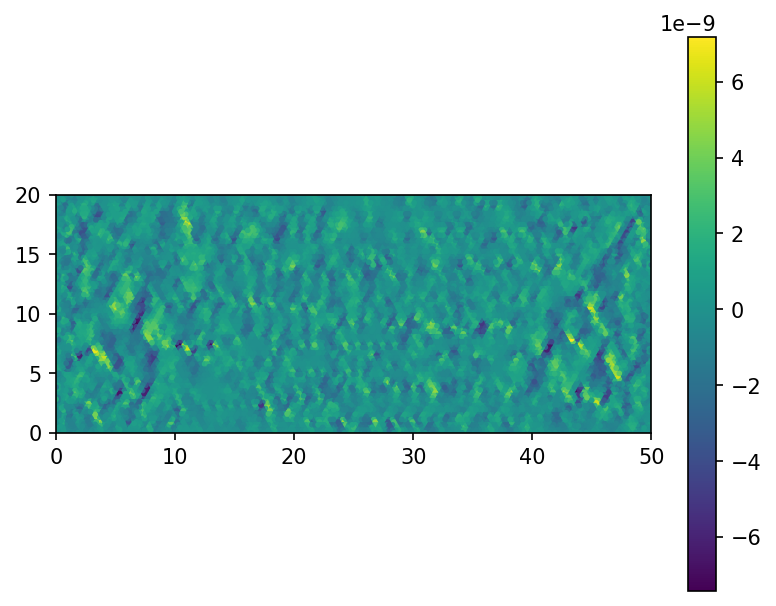

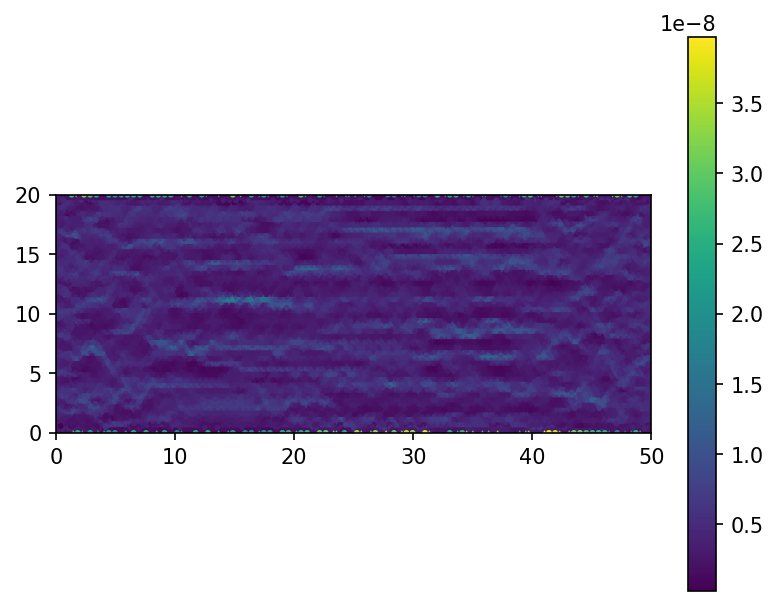

In [25]:
# import matplotlib.pyplot as plt

# with mesh.access(v_soln):
#     fig, ax = plt.subplots(dpi = 150)
#     out = ax.scatter(dim(v_soln.coords[:, 0], u.meter)/1e3, dim(v_soln.coords[:, 1], u.meter)/1e3, c = dim(v_soln.data[:, 0], u.meter/u.second), s = 3)
#     fig.colorbar(out)
#     ax.set_aspect("equal")
#     ax.set_xlim([0, 50])
#     ax.set_ylim([0, 20])

#     fig, ax = plt.subplots(dpi = 150)
#     out = ax.scatter(dim(v_soln.coords[:, 0], u.meter)/1e3, dim(v_soln.coords[:, 1], u.meter)/1e3, c = dim(v_soln.data[:, 1], u.meter/u.second), s = 3)
#     fig.colorbar(out)
#     ax.set_aspect("equal")
#     ax.set_xlim([0, 50])
#     ax.set_ylim([0, 20])